In [25]:
#!/usr/bin/env python
# coding: utf-8
"""
PPO implementation for CartPole-v1 (gymnasium).
- Batched rollouts, clipped surrogate, multiple epochs & minibatches.
- Shared actor-critic network.
"""
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as distributions

import matplotlib.pyplot as plt
import numpy as np
import random
import gymnasium

In [26]:
# ----------------------------
# Device & seed
# ----------------------------
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    # MPS may not be desirable for RL but we check
    try:
        if torch.backends.mps.is_available():
            return torch.device("mps")
    except Exception:
        pass
    return torch.device("cpu")

In [27]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

In [28]:
# ----------------------------
# Actor-Critic network (shared body)
# ----------------------------
class ActorCritic(nn.Module):
    def __init__(self, obs_dim, hidden_dim, action_dim):
        super().__init__()
        self.fc1 = nn.Linear(obs_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # actor head
        self.actor = nn.Linear(hidden_dim, action_dim)
        # critic head
        self.critic = nn.Linear(hidden_dim, 1)

        # initialize
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        # x: [batch, obs]
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        logits = self.actor(x)         # action logits
        value = self.critic(x)         # state value (scalar)
        return logits, value

In [29]:
# ----------------------------
# Returns & helper functions
# ----------------------------
def calculate_returns(rewards, gamma, device, normalize=True):
    """Compute discounted returns (per episode)."""
    returns = []
    R = 0.0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    returns = torch.tensor(returns, dtype=torch.float32, device=device)
    if normalize:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns

In [30]:
def collect_episodes(env, policy, n_episodes, device, gamma):
    """
    Collect n_episodes complete episodes (sequentially) and return concatenated
    tensors for states, actions, old_log_probs, returns, values, and episode rewards.
    """
    states = []
    actions = []
    log_probs_old = []
    returns_list = []
    values = []
    episode_rewards = []

    for episode_idx in range(n_episodes):
        ep_states = []
        ep_actions = []
        ep_log_probs = []
        ep_rewards = []
        ep_values = []

        done = False
        state, _ = env.reset()
        while not done:
            if episode_idx == 1:
                env.render()
            s_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)  # [1, obs]
            logits, value = policy(s_t)  # logits: [1, A], value: [1,1]
            dist = distributions.Categorical(logits=logits)
            action = dist.sample()       # [1]
            logp = dist.log_prob(action) # [1]

            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated

            ep_states.append(s_t)                # list of tensors [1,obs]
            ep_actions.append(action.squeeze(0)) # tensor scalar
            ep_log_probs.append(logp.squeeze(0)) # tensor scalar
            ep_rewards.append(reward)
            ep_values.append(value.squeeze(0))   # scalar tensor
            

            state = next_state

        # episode end: compute returns for episode
        ep_returns = calculate_returns(ep_rewards, gamma, device, normalize=False)  # normalized later optionally
        episode_rewards.append(sum(ep_rewards))

        # stack episode tensors and append to global lists
        states.append(torch.cat(ep_states, dim=0))         # [T, obs]
        actions.append(torch.stack(ep_actions))            # [T]
        log_probs_old.append(torch.stack(ep_log_probs))    # [T]
        returns_list.append(ep_returns)                    # [T]
        values.append(torch.cat(ep_values).detach())     # [T] detach values when used as baseline

    # concatenate across episodes -> final batch
    states_b = torch.cat(states, dim=0)           # [N, obs]
    actions_b = torch.cat(actions, dim=0)         # [N]
    log_probs_old_b = torch.cat(log_probs_old, dim=0).detach()   # [N]
    returns_b = torch.cat(returns_list, dim=0)    # [N]
    values_b = torch.cat(values, dim=0)           # [N]
    return states_b, actions_b, log_probs_old_b, returns_b, values_b, episode_rewards

In [31]:
# ----------------------------
# PPO update
# ----------------------------
def ppo_update(policy, optimizer, states, actions, old_log_probs, returns, values,
               ppo_epochs=4, minibatch_size=64, clip_eps=0.2,
               vf_coef=0.5, ent_coef=0.01, max_grad_norm=0.5):

    device = states.device
    advantages = (returns - values).squeeze()
    advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

    N = states.shape[0]
    total_policy_loss = total_value_loss = total_entropy = 0.0
    n_updates = 0

    # print(states.shape, actions.shape, old_log_probs.shape, returns.shape, values.shape, advantages.shape)

    for epoch in range(ppo_epochs):
        perm = torch.randperm(N, device=device)
        for start in range(0, N, minibatch_size):
            idx = perm[start:start + minibatch_size]

            s_mb = states[idx]
            a_mb = actions[idx].squeeze()
            old_logp_mb = old_log_probs[idx].squeeze()
            return_mb = returns[idx].squeeze()
            adv_mb = advantages[idx].squeeze()
            logits, value_pred = policy(s_mb)
            value_pred = value_pred.squeeze(-1)

            dist = distributions.Categorical(logits=logits)
            new_logp_mb = dist.log_prob(a_mb)
            entropy_mb = dist.entropy().mean()

            ratio = (new_logp_mb - old_logp_mb).exp()
            surr1 = ratio * adv_mb
            surr2 = torch.clamp(ratio, 1.0 - clip_eps, 1.0 + clip_eps) * adv_mb
            policy_loss = -torch.min(surr1, surr2).mean()

            value_loss = F.mse_loss(value_pred, return_mb, reduction='mean')

            loss = policy_loss + vf_coef * value_loss - ent_coef * entropy_mb

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(policy.parameters(), max_grad_norm)
            optimizer.step()

            total_policy_loss += policy_loss.item()
            total_value_loss += value_loss.item()
            total_entropy += entropy_mb.item()
            n_updates += 1

    return total_policy_loss / n_updates, total_value_loss / n_updates, total_entropy / n_updates

In [32]:
# ----------------------------
# Main training loop
# ----------------------------

# envs
visualize_test_episodes = False

train_env = gymnasium.make('CartPole-v1', render_mode=None)
if visualize_test_episodes == True:
    test_env = gymnasium.make('CartPole-v1', render_mode="human")
else:
    test_env = gymnasium.make('CartPole-v1', render_mode=None)

# hyperparams
SEED = 1234
set_seed(SEED)
train_env.reset(seed=SEED)
test_env.reset(seed=SEED + 1)

device = get_device()
print("Device:", device)

obs_dim = train_env.observation_space.shape[0]
action_dim = train_env.action_space.n

policy = ActorCritic(obs_dim, hidden_dim=128, action_dim=action_dim).to(device)
optimizer = optim.Adam(policy.parameters(), lr=3e-4)

max_updates = 500           # number of update iterations (not episodes)
batch_episodes = 8           # number of episodes per update (increase to reduce variance)
ppo_epochs = 4
minibatch_size = 64
gamma = 0.99
clip_eps = 0.2
vf_coef = 0.5
ent_coef = 0.01

print_every = 1
reward_threshold = 475
recent_rewards = []

train_rewards_log = []
test_rewards_log = []

episodes_seen = 0
for update in range(1, max_updates + 1):
    # collect rollouts (batch of full episodes)
    states_b, actions_b, old_logp_b, returns_b, values_b, episode_rewards = collect_episodes(
        train_env, policy, n_episodes=batch_episodes, device=device, gamma=gamma
    )
    episodes_seen += len(episode_rewards)
    train_rewards_log.extend(episode_rewards)
    recent_rewards.extend(episode_rewards)
    # normalize returns across the whole batch (optional but helps)
    returns_b = (returns_b - returns_b.mean()) / (returns_b.std() + 1e-8)

    # PPO update
    p_loss, v_loss, ent = ppo_update(
        policy, optimizer,
        states_b, actions_b, old_logp_b, returns_b, values_b,
        ppo_epochs=ppo_epochs, minibatch_size=minibatch_size, clip_eps=clip_eps,
        vf_coef=vf_coef, ent_coef=ent_coef
    )

    # evaluate on test env periodically
    if update % print_every == 0:
        # run one deterministic evaluation episode
        policy.eval()
        s, _ = test_env.reset()
        done = False
        total_reward = 0
        while not done:
            s_t = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                logits, _ = policy(s_t)
                action = torch.argmax(logits, dim=-1).item()
            s, r, term, trunc, _ = test_env.step(action)
            done = term or trunc
            total_reward += r
            if visualize_test_episodes == True:
                test_env.render()
        test_rewards_log.append(total_reward)

        recent_mean = np.mean(recent_rewards[-100:]) if len(recent_rewards) > 0 else 0.0
        print(f"Update {update:4d} | Episodes {episodes_seen:4d} | AvgEpReward(last {min(100,len(recent_rewards))}): {recent_mean:6.2f} | "
              f"P_loss {p_loss:.4f} V_loss {v_loss:.4f} Ent {ent:.4f} | TestReward {total_reward:.1f}")

    # stopping criteria using last 100 episode average
    if len(recent_rewards) >= 100 and np.mean(recent_rewards[-100:]) >= reward_threshold:
        print(f"Stopping at update {update} — avg 100-ep reward {np.mean(recent_rewards[-100:]):.1f}")
        break

Device: cpu
Update    1 | Episodes    8 | AvgEpReward(last 8):  23.62 | P_loss -0.0057 V_loss 0.9483 Ent 0.6906 | TestReward 9.0
Update    2 | Episodes   16 | AvgEpReward(last 16):  24.56 | P_loss -0.0377 V_loss 0.9478 Ent 0.6868 | TestReward 163.0
Update    3 | Episodes   24 | AvgEpReward(last 24):  24.62 | P_loss 0.0754 V_loss 0.8057 Ent 0.6828 | TestReward 41.0
Update    4 | Episodes   32 | AvgEpReward(last 32):  24.59 | P_loss 0.0668 V_loss 0.7864 Ent 0.6703 | TestReward 65.0
Update    5 | Episodes   40 | AvgEpReward(last 40):  26.20 | P_loss 0.0096 V_loss 0.8305 Ent 0.6828 | TestReward 170.0
Update    6 | Episodes   48 | AvgEpReward(last 48):  25.77 | P_loss -0.0021 V_loss 0.6949 Ent 0.6722 | TestReward 96.0
Update    7 | Episodes   56 | AvgEpReward(last 56):  29.54 | P_loss 0.0054 V_loss 0.9137 Ent 0.6645 | TestReward 374.0
Update    8 | Episodes   64 | AvgEpReward(last 64):  29.33 | P_loss -0.0037 V_loss 0.7802 Ent 0.6490 | TestReward 210.0
Update    9 | Episodes   72 | AvgEpRew

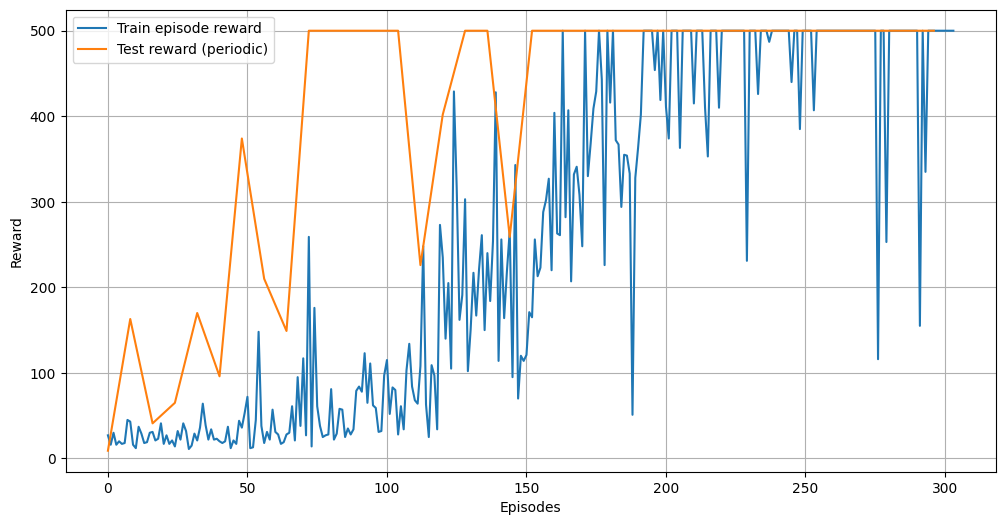

In [33]:
# Plot training & test rewards
plt.figure(figsize=(12, 6))
plt.plot(train_rewards_log, label="Train episode reward")
plt.plot(np.arange(0, len(test_rewards_log)) * print_every * batch_episodes, test_rewards_log, label="Test reward (periodic)")
plt.xlabel("Episodes")
plt.ylabel("Reward")
plt.legend()
plt.grid()
plt.show()